# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filename2 = 'newDB'#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [3]:
if False:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)
    data['phi0'] = data['phi0'].astype('int32')
    data['centrality'] = data['centrality'].astype('int32')
    data['zvertex'] = data['zvertex'].astype('float16')
    data['pt'] = data['pt'].astype('float16')
    data['e/p'] = data['e/p'].astype('float16')
    data['n0'] = data['n0'].astype('int32')
    data['disp'] = data['disp'].astype('float16')
    data['chi2'] = data['chi2'].astype('float16')
    data['npe0'] = data['npe0'].astype('int32')
    data['prob'] = data['prob'].astype('float16')
    data.head()
    
    data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
    data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
    data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
    data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
    data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
    data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
    #data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
    #data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
    data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
    data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
    data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
    data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
    data.head()

In [4]:
data = pd.read_csv(filepath+f'{filename2}.csv')
#data2.loc[data2['phi0'] > -99, 'phi0'] = 1
#data2 = data2[:100000]

In [5]:
print(data.size, data.shape)

341659176 (14235799, 24)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


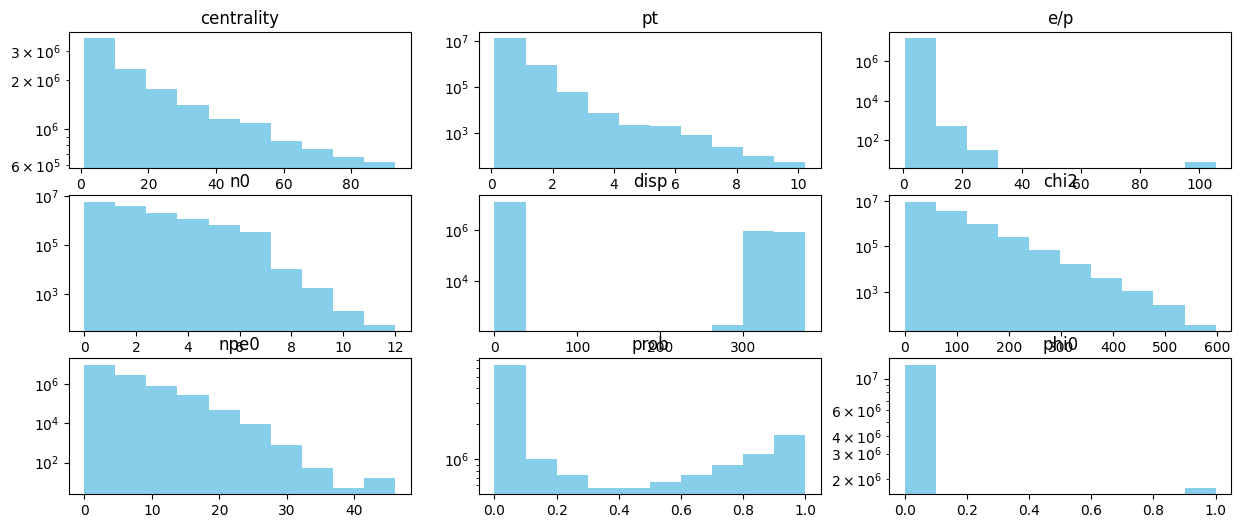

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

In [10]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [11]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

4745266 9490533


In [12]:
transformed_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob,disp2,n0*disp,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
9490533,29,0.3477,0.9720,2,6.387,49.600,1,0.020360,40.790176,0.000000,...,0.000603,0.000000,1.010331,0.017478,0.000000,0.0,0.029642,2.876404,0.120865,0.001189
9490534,45,0.4900,0.7000,1,4.870,9.210,1,0.925300,23.727554,-0.170326,...,-0.009217,-0.926293,3.658392,-0.006973,-0.700707,-1.0,-0.009961,2.040857,0.240090,0.000494
9490535,6,0.5596,1.5530,0,336.500,42.530,0,0.000054,113232.250000,-0.005926,...,0.000030,-0.002108,1.000022,0.423849,-1.497425,-0.0,0.566609,1.787086,0.313119,0.027778
9490536,31,0.5425,0.6353,3,2.805,17.340,4,0.816000,7.866272,0.262834,...,-0.022145,0.816918,2.330679,-0.019990,0.737211,3.0,-0.027141,1.843384,0.294285,0.001041
9490537,14,0.4873,0.7120,1,6.010,14.770,2,0.560500,36.140762,-0.142618,...,-0.004349,-0.561547,1.508477,-0.005416,-0.698788,-1.0,-0.007759,2.052104,0.237466,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14235794,52,0.5060,1.1630,1,9.130,100.750,2,0.000076,83.408264,-0.098689,...,0.000010,-0.001076,1.000033,0.093763,-0.711941,-1.0,0.131831,1.976834,0.255894,0.000370
14235795,57,0.5405,0.6500,0,343.800,13.840,0,0.000428,118164.062500,-0.005801,...,-0.000010,-0.002855,1.000209,-0.016564,-1.471771,-0.0,-0.022529,1.850045,0.292170,0.000308
14235796,47,0.5127,0.8594,1,8.100,0.617,2,0.013176,65.635315,-0.109871,...,0.000046,-0.014176,1.006649,0.002524,-0.716725,-1.0,0.003525,1.950476,0.262856,0.000453
14235797,31,0.5757,0.9940,1,8.664,27.470,1,0.007748,75.065979,-0.103476,...,0.000292,-0.008748,1.003891,0.028597,-0.759397,-1.0,0.037691,1.737065,0.331412,0.001041


In [13]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [15]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [16]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.0001,0.001,0.01,0.05,0.1,1,10,100,1000,10000]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [17]:
print(transformed_val.shape,y_val.shape)

(4745267, 22) (4745267,)


In [18]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 1623.4941991730032 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 584.9652169019487 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 246.24381777823515 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 142.45672855971196 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 80.28221064944248 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 24.02466304081971 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.137470735497903 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.0728428747464155 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 4.148187593364911e-05 <= 0.0001
    2. Newton decrement 4.3881509820581824e-10 <= 0.0001
  Solver did converge at loss = 0.18452967434842996.
localy best C: 0.0001
Newton iter=1
  Check Convergence
    1. max |gradient| 1621.398849365463 <= 0.0001
Newton iter=2
  Chec

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [19]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 1614.2817689419855 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 571.8142137277309 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 223.4800220184778 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 103.33179059546329 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 54.59005408894938 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 20.722553512304565 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.2909468553844197 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.11393116164729328 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 0.0004476116104154366 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 3.727139536937279e-08 <= 0.0001
    2. Newton decrement 3.0298548487298765e-11 <= 0.0001
  Solver did converge at loss = 0.17108381701905534.


LogisticRegression(C=0.05, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [20]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [21]:
clf

LogisticRegression(C=0.05, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.16875449389653988
roc auc: 0.948561911295735
f1 score: 0.6573268773981363


Text(0.5, 1.0, 'ROC AUC Curve')

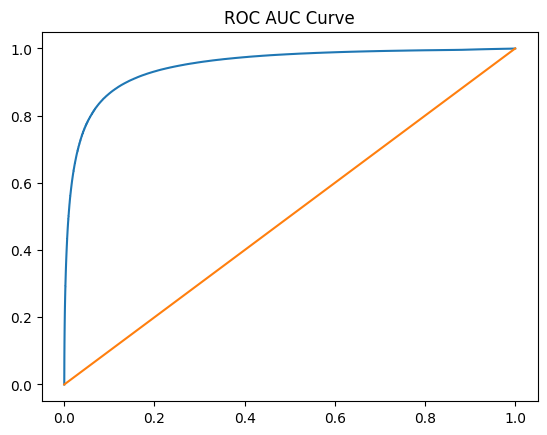

In [22]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [23]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.36941503874780507


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [24]:
i = 36000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.57 0.0247
0.5980331947300741 0.014067051233534921 0.569755639751121


In [25]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")

[-6.53545671]
0.021353069628557673
3.095279485270983
4.6382682200866014
-1.8282220434020535
-0.3175938636551022
-0.005021594683382745
0.2137918331373416
2.549257410200321
0.0008447746909219362
-7.047608340577657
9.517728631140908
7.72718467238114e-06
-4.149802548708278
0.043061809621984096
-0.005526510133862617
-4.888545044572229
0.048892128987606254
-0.17396866101759953
0.19471665020363357
0.44385071211159094
-0.6073048793423969
-0.4145894647254969


In [26]:
def answer(centrality,pt,ep,n0,disp,chi2,npe0,prob):
    ans = clf.coef_[0][0]*centrality+clf.coef_[0][1]*pt+clf.coef_[0][2]*ep+clf.coef_[0][3]*n0+\
        clf.coef_[0][4]*disp+clf.coef_[0][5]*chi2+clf.coef_[0][6]*npe0+clf.coef_[0][7]*prob+clf.intercept_[0]
    return ans

In [27]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.01789709787853305


In [28]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    if counter<10: 
        print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

[0.9821029 0.0178971] -4.584383858989346
[0.94405054 0.05594946] -1.1689460601287998
[0.99292798 0.00707202] -5.401172199730233
[0.94435972 0.05564028] -1.6382875392803573
[0.62569398 0.37430602] -7.765042163484157
[0.99826812 0.00173188] -6.872375927083802
[0.99734664 0.00265336] -4.1600957217368935
[0.88734095 0.11265905] -4.938941484253226
[0.9948106 0.0051894] -1.2789849730967333
[0.39055378 0.60944622] -2.351107580190833


In [29]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

10684 83748 0.523 0.013 0.583 0.013 0.023 0.025


In [30]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.119 1.115 0.996 1324
